In [1]:
import cyecca.lie as lie
import casadi as ca
from cyecca.graph import draw_casadi
import numpy as np

import matplotlib.pyplot as plt
from cyecca.symbolic import casadi_to_sympy

In [2]:
def derive_dynamics_linearization():
    w = ca.SX.sym("w", 3)  # process noise
    v = ca.SX.sym("v", 3)  # measurement noise
    x = lie.so3.elem(ca.SX.sym("x", 3))  # state

    xh = ca.vertcat(1, 0, 0)  # x unit vector
    zh = ca.vertcat(0, 0, 1)  # z unit vector

    accel_noise_str = ca.SX.sym("accel_noise_str")
    g = ca.SX.sym("g")

    omega = lie.so3.elem(ca.SX.sym("omega", 3))  # angular velocity
    qr = lie.SO3Quat.elem(ca.SX.sym("qr", 4))
    qe = x.exp(lie.SO3Quat)

    A = -omega.ad()
    J_r_inv = lie.so3.right_jacobian_inv(x)

    x_dot = A @ x.param + J_r_inv @ w

    q = lie.SO3Quat.elem(ca.SX.sym("q", 4))
    qr = lie.SO3Quat.elem(ca.SX.sym("qr", 4))
    xe = (q.inverse() * qr).log()
    f_log_error_quat = ca.Function(
        "log_error_quat", [q.param, qr.param], [xe.param], ["q", "qr"], ["xi"]
    )
    f_log_error_quat([1, 0, 0, 0], [1, 0, 0, 0])

    q1 = q * omega.exp(lie.SO3Quat)
    f_exp_quat = ca.Function(
        "exp_quat", [q.param, omega.param], [q1.param], ["q", "omega"], ["q1"]
    )
    f_exp_quat([1, 0, 0, 0], [1, 2, 3])

    return {
        "f_log_error_quat": f_log_error_quat,
        "f_exp_quat": f_exp_quat,
    }


derive_dynamics_linearization()

{'f_log_error_quat': Function(log_error_quat:(q[4],qr[4])->(xi[3]) SXFunction),
 'f_exp_quat': Function(exp_quat:(q[4],omega[3])->(q1[4]) SXFunction)}

In [3]:
def derive_accel_measurement():
    v = ca.SX.sym("v", 3)  # measurement noise
    x = lie.so3.elem(ca.SX.sym("x", 3))  # state (lie algebra)
    zh = ca.vertcat(0, 0, 1)  # z unit vector
    accel_noise_str = ca.SX.sym("accel_noise_str")
    g = ca.SX.sym("g")
    qr = lie.SO3Quat.elem(ca.SX.sym("qr", 4))
    qe = x.exp(lie.SO3Quat)

    # parameterize measurements in exponential coordinates
    y_accel = (qe * qr).inverse() @ (g * zh) + v * accel_noise_str

    f_g_accel = ca.Function(
        "g_accel",
        [x.param, qr.param, v, g, accel_noise_str],
        [y_accel],
        ["x", "qr", "v", "g", "accel_noise_str"],
        ["y_accel"],
    )
    H_accel = ca.jacobian(y_accel, x.param)
    f_H_accel = ca.Function(
        "H_accel", [x.param, qr.param, g], [H_accel], ["x", "qr", "g"], ["H_accel"]
    )
    N_accel = ca.jacobian(y_accel, v)
    f_N_accel = ca.Function(
        "N_accel",
        [x.param, qr.param, g, accel_noise_str],
        [N_accel],
        ["x", "qr", "g", "accel_noise_str"],
        ["N_accel"],
    )

    # test
    euler0 = lie.SO3EulerB321.elem(ca.vertcat(0, 0, 0))
    q0 = lie.SO3Quat.from_Euler(euler0)
    ca.DM(f_H_accel([0, 0, 0], q0.param, 9.8))

    return {"f_g_accel": f_g_accel, "f_H_accel": f_H_accel, "f_N_accel": f_N_accel}


derive_accel_measurement()

{'f_g_accel': Function(g_accel:(x[3],qr[4],v[3],g,accel_noise_str)->(y_accel[3]) SXFunction),
 'f_H_accel': Function(H_accel:(x[3],qr[4],g)->(H_accel[3x3]) SXFunction),
 'f_N_accel': Function(N_accel:(x[3],qr[4],g,accel_noise_str)->(N_accel[3x3,3nz]) SXFunction)}

In [4]:
def derive_mag_measurement():
    # parameters
    mag_decl = ca.SX.sym("decl")
    mag_incl = ca.SX.sym("incl")
    mag_str = ca.SX.sym("mag_str")
    mag_noise_str = ca.SX.sym("mag_noise_str")

    # inputs
    v = ca.SX.sym("v", 3)  # measurement noise
    x = lie.so3.elem(ca.SX.sym("x", 3))  # state (lie algebra)
    qr = lie.SO3Quat.elem(ca.SX.sym("qr", 4))

    def sub_est_zero_error(expr):
        expr = ca.substitute(expr, x.param, [0, 0, 0])
        expr = ca.substitute(expr, v, [0, 0, 0])
        return expr

    # constants
    xh = ca.vertcat(1, 0, 0)  # x unit vector
    zh = ca.vertcat(0, 0, 1)  # z unit vector

    # quaterions SO3 Lie group
    qe = x.exp(lie.SO3Quat)
    q_wb = qe * qr
    q_bw = q_wb.inverse()

    R_mag = lie.SO3EulerB321.elem(ca.vertcat(mag_decl, mag_incl, 0))
    B_w = R_mag @ (mag_str * xh)  # magnetic field vector in world frame

    y_mag_b = q_bw @ B_w + v * mag_noise_str  # true measurement of accelerometer

    # create pseudo measurement which is normalized planar projection into world xy plane
    # this prevents correction or roll/pitch from magnetic heading
    y_magp_b = y_mag_b - ca.dot(y_mag_b, q_bw @ zh) * y_mag_b / ca.norm_2(
        y_mag_b
    )  # project magnetic field into world xy plane
    y_magp_b = sub_est_zero_error(y_magp_b)

    H_mag = sub_est_zero_error(ca.jacobian(y_magp_b, x.param))
    R_mag = sub_est_zero_error(ca.jacobian(y_magp_b, v))

    # define functions
    f_g_mag = ca.Function(
        "g_magp_b",
        [qr.param, v, mag_decl, mag_incl, mag_str, mag_noise_str],
        [y_magp_b],
        ["qr", "v", "mag_decl", "mag_incl", "mag_str", "mag_noise_str"],
        ["y_magp"],
    )

    # kalman update
    y_mag_meas = ca.SX.sym("y_mag", 3)
    P = ca.SX.sym("P", 3, 3)
    S = H_mag @ P @ H_mag.T + R_mag
    K = P @ H_mag.T @ ca.inv(S)
    P1 = (ca.SX.eye(3) - K @ H_mag) @ P

    y_mag_est = f_g_mag(qr.param, [0, 0, 0], mag_decl, mag_incl, mag_str, mag_noise_str)

    # project measured measurement, so no correction in yaw direction
    y_mag_meas_proj = y_mag_meas - ca.dot(
        y_mag_meas, q_bw @ zh
    ) * y_mag_meas / ca.norm_2(y_mag_meas)
    y_mag_meas_proj = sub_est_zero_error(y_mag_meas_proj)

    q1 = qr * (lie.so3.elem(K @ (y_mag_meas_proj - y_mag_est))).exp(lie.SO3Quat)

    f_mag_kalman_update = ca.Function(
        "kalman_update",
        [y_mag_meas, qr.param, P, mag_decl, mag_incl, mag_str, mag_noise_str],
        [q1.param, P1],
        ["y_mag", "q0", "P0", "mag_decl", "mag_incl", "mag_str", "mag_noise_str"],
        ["q1", "P1"],
    )

    return {
        "f_g_mag": f_g_mag,
        "f_mag_kalman_update": f_mag_kalman_update,
    }


derive_mag_measurement()

{'f_g_mag': Function(g_magp_b:(qr[4],v[3],mag_decl,mag_incl,mag_str,mag_noise_str)->(y_magp[3]) SXFunction),
 'f_mag_kalman_update': Function(kalman_update:(y_mag[3],q0[4],P0[3x3],mag_decl,mag_incl,mag_str,mag_noise_str)->(q1[4],P1[3x3]) SXFunction)}

In [5]:
def simulate():
    eqs = {}
    eqs.update(derive_accel_measurement())
    eqs.update(derive_mag_measurement())
    eqs.update(derive_dynamics_linearization())

    tf = 1
    dt = 0.01
    g = 9.8
    mag_incl = 0
    mag_decl = 0
    mag_str = 0.1
    mag_noise_str = 0.01
    accel_noise_str = 0.1

    omega_b = np.array([1, 2, 3])

    x = np.array([1, 0, 0, 0])
    x_est = np.array([1, 0, 0, 0])

    P = (10 * np.eye(3)).reshape(-1)

    data = {
        "t": [],
        "x": [],
        "x_est": [],
        "y_mag": [],
        "y_accel": [],
        "y_gyro": [],
        "P": [],
    }

    for ti in np.arange(0, tf, dt):
        # simulation
        x = np.array(eqs["f_exp_quat"](x, omega_b * dt)).reshape(-1)
        y_gyro = omega_b + np.random.randn(3)
        y_mag = np.array(
            eqs["f_g_mag"](
                x, np.random.randn(3), mag_decl, mag_incl, mag_str, mag_noise_str
            )
        ).reshape(-1)
        y_accel = np.array(
            eqs["f_g_accel"]([0, 0, 0], x, np.random.randn(3), g, accel_noise_str)
        ).reshape(-1)

        # prediction
        x_est = np.array(eqs["f_exp_quat"](x_est, y_gyro * dt)).reshape(-1)

        # y_mag[3],q0[4],P0[3x3],mag_decl,mag_incl,mag_str,mag_noise_str)->(q1[4],P1[3x3])
        [x_est, P] = eqs["f_mag_kalman_update"](
            y_mag, x, np.reshape(P, (3, 3)), mag_decl, mag_incl, mag_str, mag_noise_str
        )
        print(P)
        x_est = np.array(x).reshape(-1)
        P = np.array(P).reshape(-1)
        print(P)

        # store data
        data["t"].append(ti)
        data["x"].append(x)
        data["x_est"].append(x_est)
        data["y_mag"].append(y_mag)
        data["y_accel"].append(y_accel)
        data["y_gyro"].append(y_gyro)
        data["P"].append(P)

    for k in data.keys():
        data[k] = np.array(data[k])

    return data


data = simulate()


[[10, 0, 0], 
 [0, 10, 0], 
 [0, 0, 10]]
[10.  0.  0.  0. 10.  0.  0.  0. 10.]

[[10, 0, 0], 
 [0, 10, 0], 
 [0, 0, 10]]
[10.  0.  0.  0. 10.  0.  0.  0. 10.]

[[10, 0, 0], 
 [0, 10, 0], 
 [0, 0, 10]]
[10.  0.  0.  0. 10.  0.  0.  0. 10.]

[[10, 0, 0], 
 [0, 10, 0], 
 [0, 0, 10]]
[10.  0.  0.  0. 10.  0.  0.  0. 10.]

[[10, 0, 0], 
 [0, 10, 0], 
 [0, 0, 10]]
[10.  0.  0.  0. 10.  0.  0.  0. 10.]

[[10, 0, 0], 
 [0, 10, 0], 
 [0, 0, 10]]
[10.  0.  0.  0. 10.  0.  0.  0. 10.]

[[10, 0, 0], 
 [0, 10, 0], 
 [0, 0, 10]]
[10.  0.  0.  0. 10.  0.  0.  0. 10.]

[[10, 0, 0], 
 [0, 10, 0], 
 [0, 0, 10]]
[10.  0.  0.  0. 10.  0.  0.  0. 10.]

[[10, 0, 0], 
 [0, 10, 0], 
 [0, 0, 10]]
[10.  0.  0.  0. 10.  0.  0.  0. 10.]

[[10, 0, 0], 
 [0, 10, 0], 
 [0, 0, 10]]
[10.  0.  0.  0. 10.  0.  0.  0. 10.]

[[10, 0, 0], 
 [0, 10, 0], 
 [0, 0, 10]]
[10.  0.  0.  0. 10.  0.  0.  0. 10.]

[[10, 0, 0], 
 [0, 10, 0], 
 [0, 0, 10]]
[10.  0.  0.  0. 10.  0.  0.  0. 10.]

[[10, 0, 0], 
 [0, 10, 0], 
 [0, 0, 10]

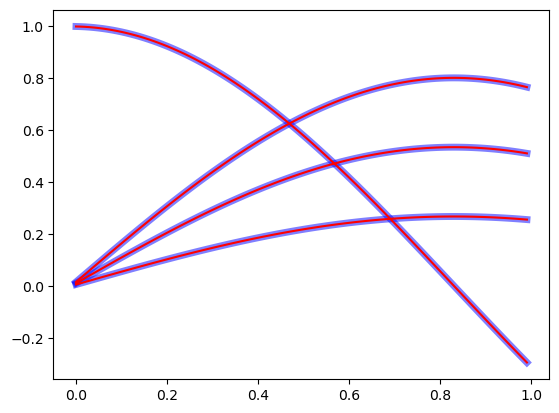

In [6]:
plt.plot(data["t"], data["x"], "b-", linewidth=5, alpha=0.5)
plt.plot(data["t"], data["x_est"], "r-");